In [24]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize

In [6]:
with open('/Users/victor/Downloads/2016_Oct_10--2017_Jan_08_full.txt', 'r') as f:
    lines = f.readlines()
    records = [l.split('\t') for l in lines]
    records = [{'conf': l[0], 's1': l[1], 's2': l[2]} for l in records]
    df = pd.DataFrame(records)

In [7]:
df['y'] = df['conf'].apply(lambda x: 0 if float(x) <= 0.5 else 1)

In [8]:
df.head()

,conf,s1,s2,y
0,0.184755415394,Jeff Sessions fought to preserve Alabamas long...,Jeff Sessions Other Civil Rights Problem\n,0
1,0.945144586603,Jeff Sessions fought to preserve Alabamas long...,How he fought to preserve Alabamas long histor...,1
2,0.0163720734413,Jeff Sessions fought to preserve Alabamas long...,Super important essay by @TomSugrue more backg...,0
3,0.796215439225,Jeff Sessions fought to preserve Alabamas long...,Alabamas public schools . still separate and u...,1
4,0.657813079179,Jeff Sessions fought to preserve Alabamas long...,"Sessions used "" power of his office 2 fight 2 ...",1


In [9]:
df['s1'] = df['s1'].apply(lambda x: word_tokenize(x.lower()))
df['s2'] = df['s2'].apply(lambda x: word_tokenize(x.lower()))

df[['y', 's1', 's2']].to_parquet('input.parquet', compression='uncompressed')

In [2]:
df = pd.read_parquet('input.parquet')

In [3]:
df.head()

,y,s1,s2
0,0,"[jeff, sessions, fought, to, preserve, alabama...","[jeff, sessions, other, civil, rights, problem]"
1,1,"[jeff, sessions, fought, to, preserve, alabama...","[how, he, fought, to, preserve, alabamas, long..."
2,0,"[jeff, sessions, fought, to, preserve, alabama...","[super, important, essay, by, @, tomsugrue, mo..."
3,1,"[jeff, sessions, fought, to, preserve, alabama...","[alabamas, public, schools, ., still, separate..."
4,1,"[jeff, sessions, fought, to, preserve, alabama...","[sessions, used, ``, power, of, his, office, 2..."


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[['s1', 's2']], df['y'],
                                                        test_size=0.1, stratify=df['y'], random_state=1234)


In [6]:
sentences = pd.concat([X_train['s1'], X_train['s2']], ignore_index=True)

max_doc_length = max([len(x) for x in sentences])
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_doc_length,
                                                                         tokenizer_fn=lambda x: x)
vocab_processor.fit(sentences)

vocab_size = len(vocab_processor.vocabulary_._mapping)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


#### Результат.
Я пробовал ислользовать подход с encoder-decoder архитектурой, где вход энкодера одна фраза, вход декодера - состояние энкодера и вторая фраза, 
а выход - softmax на последний hidden state декодера. В этом подход ошибка сначала обещающе снижалась, но потом в определенный момент переставара падать а оставалась приблизительно одинаковой (то росла то падала но оставалсь в границах одного среднего значения).
Поэтому я поискал пейперы и нашел вот эти:
- https://arxiv.org/abs/1605.09090
- https://arxiv.org/abs/1702.03814

Последний, я так понимаю, текущий state-of-the-art (или был им:)). В нем используется более advanced метод с матчинга 2х выходов с BiLSTM. Я решил с ним разобраться позже, поэтому для текущего задания взял первый. 

#### Training info
- трениновал только 5 эпох
- не использовал претренированные эмбеддинги (возможно если использовать готовые - результат улучшится)
- каждое предложение пропускается через отдельный BiLSTM с 256 hidden units 
- forward и backward outputs усредняются в зависимости от длинны входной последовательности
- после этого усредненные forward и backward outputs конкатенируются между собой (для первого и второго предложения)
- берется поэлементная разница и поэлементное произведение
- усредненые выходы BiLSTM для первого и второго предложения а также разница и произведение конкатенируются в один вектор и передаются на dense layer с 2мя выходами 
- далее софтмакс


training loss:

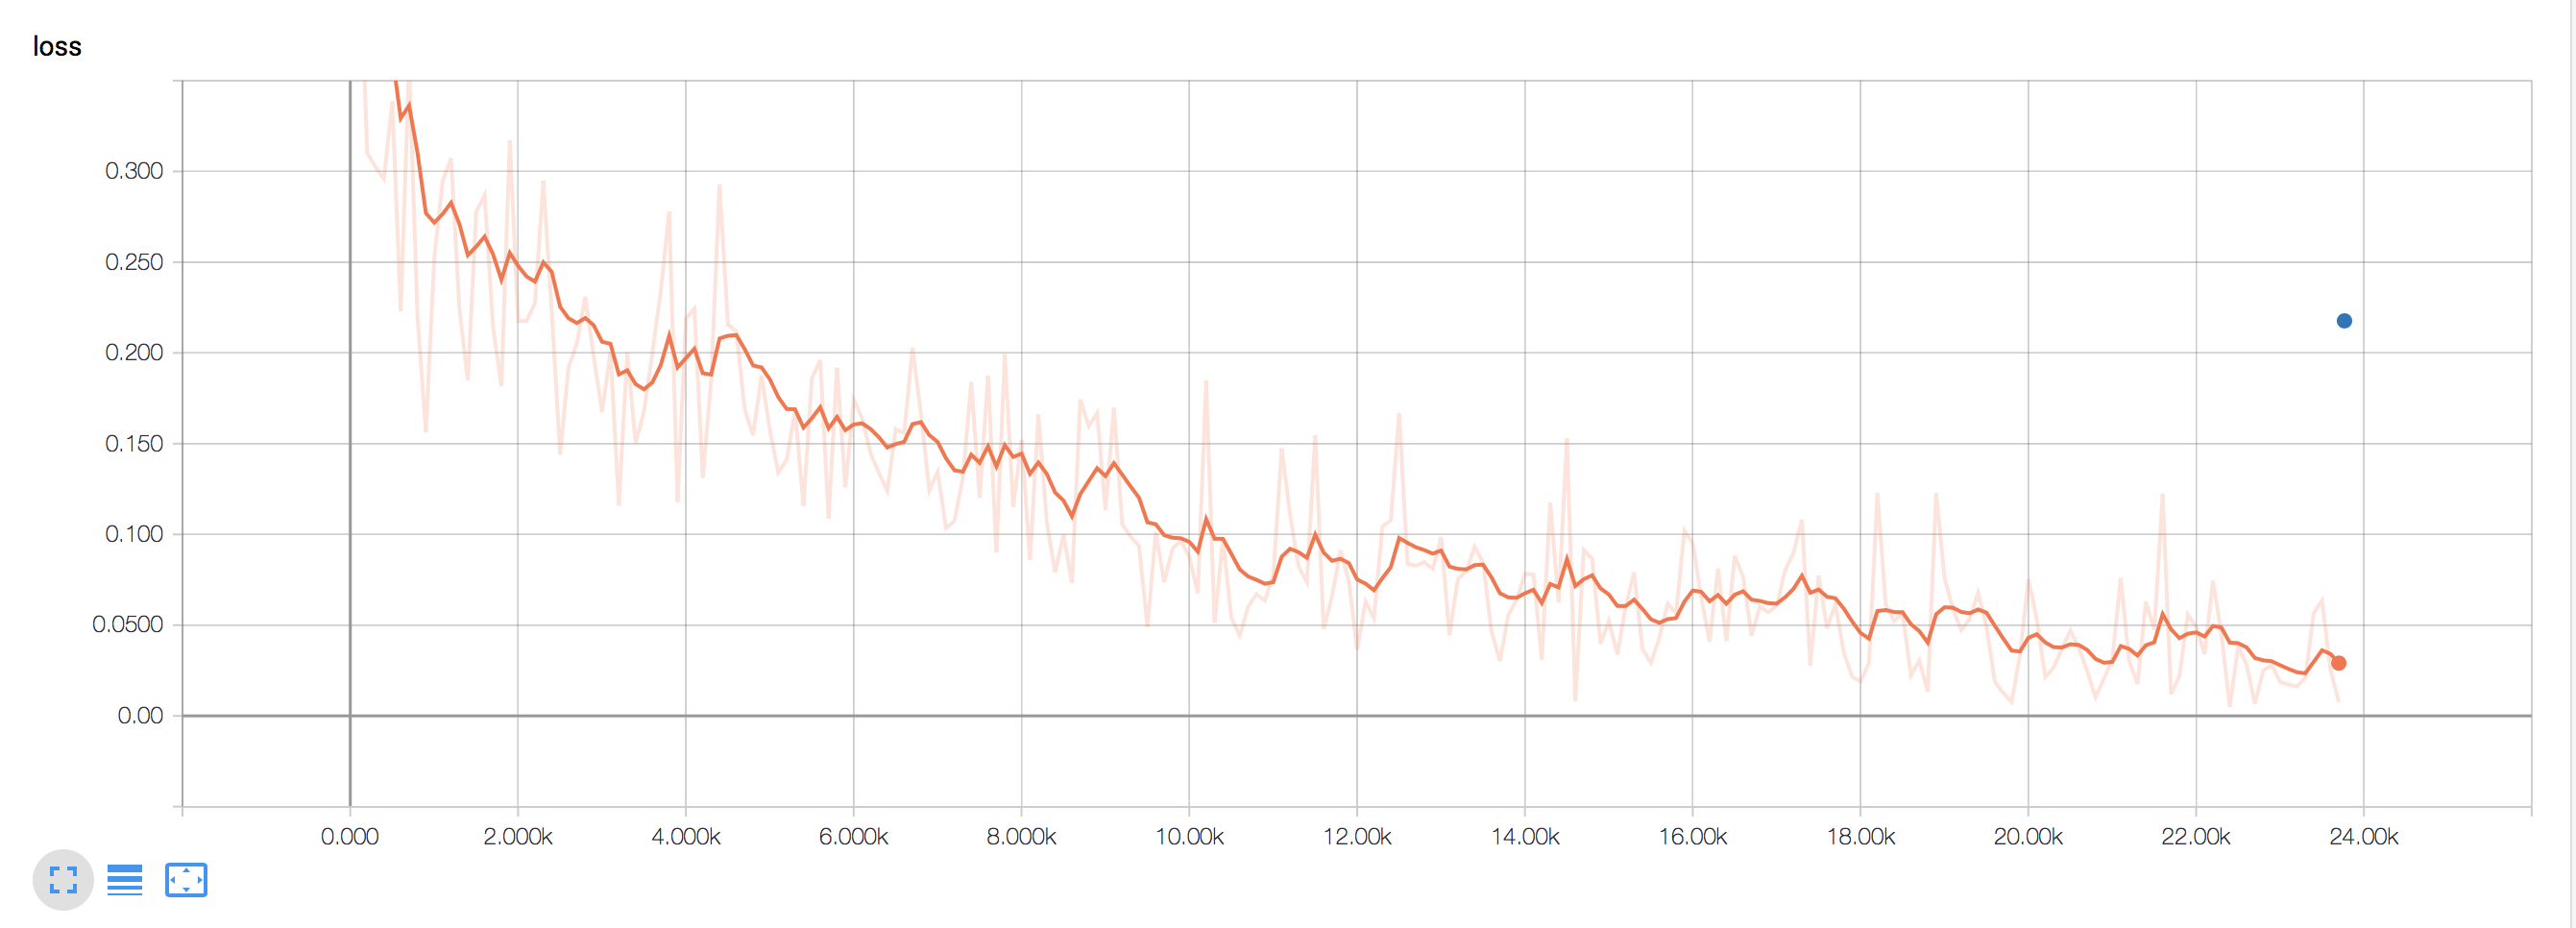

In [34]:
from IPython.display import Image
Image("loss.png")

In [18]:
from model import model

params = {
    'vocab_size': vocab_size,
    'embed_dim': 300,
    'hidden_units': 256,
}

classifier = tf.estimator.Estimator(model_fn=model, model_dir='model_bin', params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model_bin', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1ac59f550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
X_test_s1 = np.array(list(vocab_processor.transform(X_test['s1'].values)))
X_test_s2 = np.array(list(vocab_processor.transform(X_test['s2'].values)))

X_test_s1_len = np.array([len(x) for x in X_test['s1'].values])
X_test_s2_len = np.array([len(x) for x in X_test['s2'].values])

In [20]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'s1': X_test_s1,
       's2': X_test_s2,
       's1_len': X_test_s1_len,
       's2_len': X_test_s2_len},
    y=y_test.values,
    num_epochs=1,
    batch_size=128,
    shuffle=False
)

In [23]:
predictions = classifier.predict(input_fn=input_fn)
y_pred = [p['class'] for p in predictions]


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_bin/model.ckpt-23768
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [27]:
f1_score(y_test.values, y_pred, average='macro')

0.9027825451085496

In [29]:
print(classification_report(y_test.values, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     56202
          1       0.83      0.84      0.84     11403

avg / total       0.95      0.95      0.95     67605



In [30]:
confusion_matrix(y_test, y_pred)

array([[54277,  1925],
       [ 1780,  9623]])